In [ ]:
!nvidia-smi

Tue Nov 21 11:45:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W /  70W |   1557MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install ultralytics

In [ ]:
import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/166.8 GB disk)


## Cargar los datos

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=19o2GeedNeXfsALsvzb4hyqXVu_tr5wtj"
output = "pests-insects.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=19o2GeedNeXfsALsvzb4hyqXVu_tr5wtj
To: /content/pests-insects.zip
100%|██████████| 78.4M/78.4M [00:00<00:00, 138MB/s]


'pests-insects.zip'

In [ ]:
import zipfile

# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('pests-insects.zip')

Extracted all


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## Visualizar imagenes del conjunto de datos

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from ultralytics import YOLO

classes = ['bemisia-tabaci','liriomyza huidobrensis']

colors = np.random.uniform(0, 255, size=(2, 3))

def yolo2bbox(bboxes, w, h):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    ## Desnormalizar coordenadas
    xmin = int(xmin*w)
    ymin = int(ymin*h)
    xmax = int(xmax*w)
    ymax = int(ymax*h)
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Ancho de la linea.
    tf = max(lw - 1, 1) # Espesor de la fuente.

    for box_num, box in enumerate(bboxes):
        xmin, ymin, xmax, ymax = yolo2bbox(box, width, height)
        p1, p2 = (xmin, ymin), (xmax, ymax)

        class_name = classes[int(labels[box_num])]
        color=colors[classes.index(class_name)]

        ## Rectangulo de deteccion
        cv2.rectangle(
            image,
            p1,
            p2,
            color= color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        ## El rectangulo de relleno para la clase
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        ## Texto de la clase
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )

    return image

def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(18, 15))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h= label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)

        result_image = plot_box(image, bboxes, labels)
        plt.subplot(3, 3, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

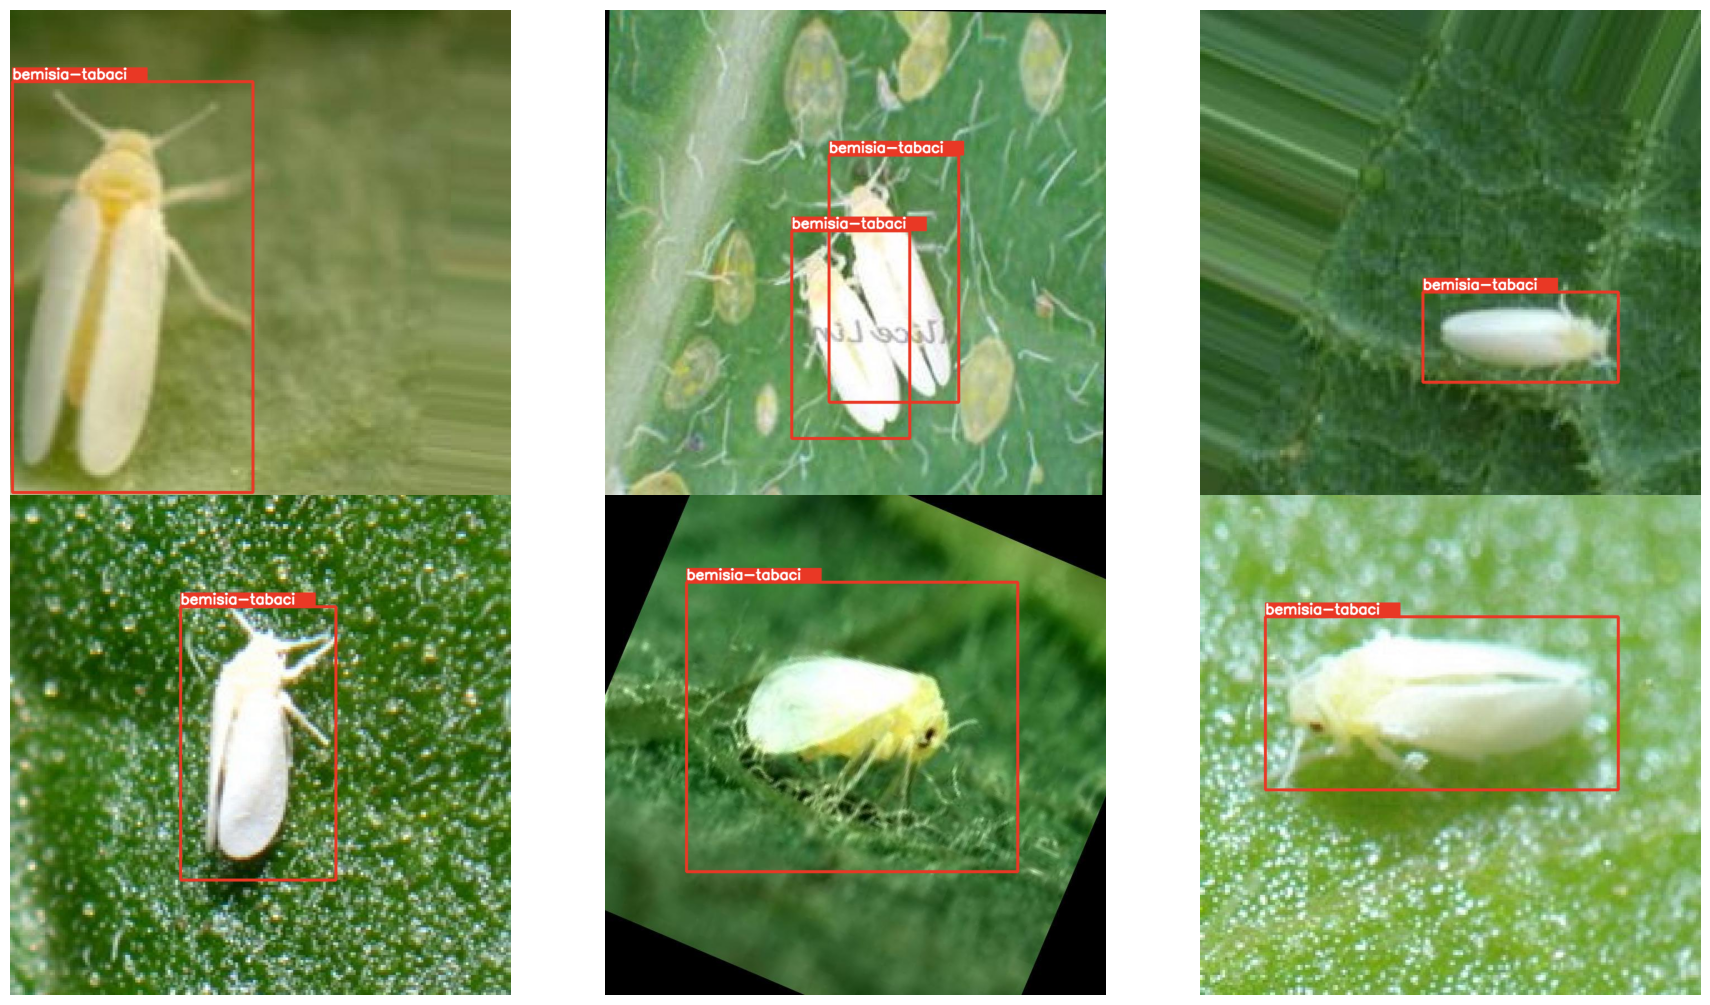

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/pests-insects/train/images',
    label_paths='/content/pests-insects/train/labels',
    num_samples=6,
)

#Entrenamiento del modelo YOLOv8n para deteccion de pestes de algodon

In [ ]:
from ultralytics import YOLO

model_tr = YOLO('yolov8n.yaml').load('yolov8n.pt')
model_tr.train(
    data='data.yaml',
    epochs=20,
    imgsz=640,
    batch = 8)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

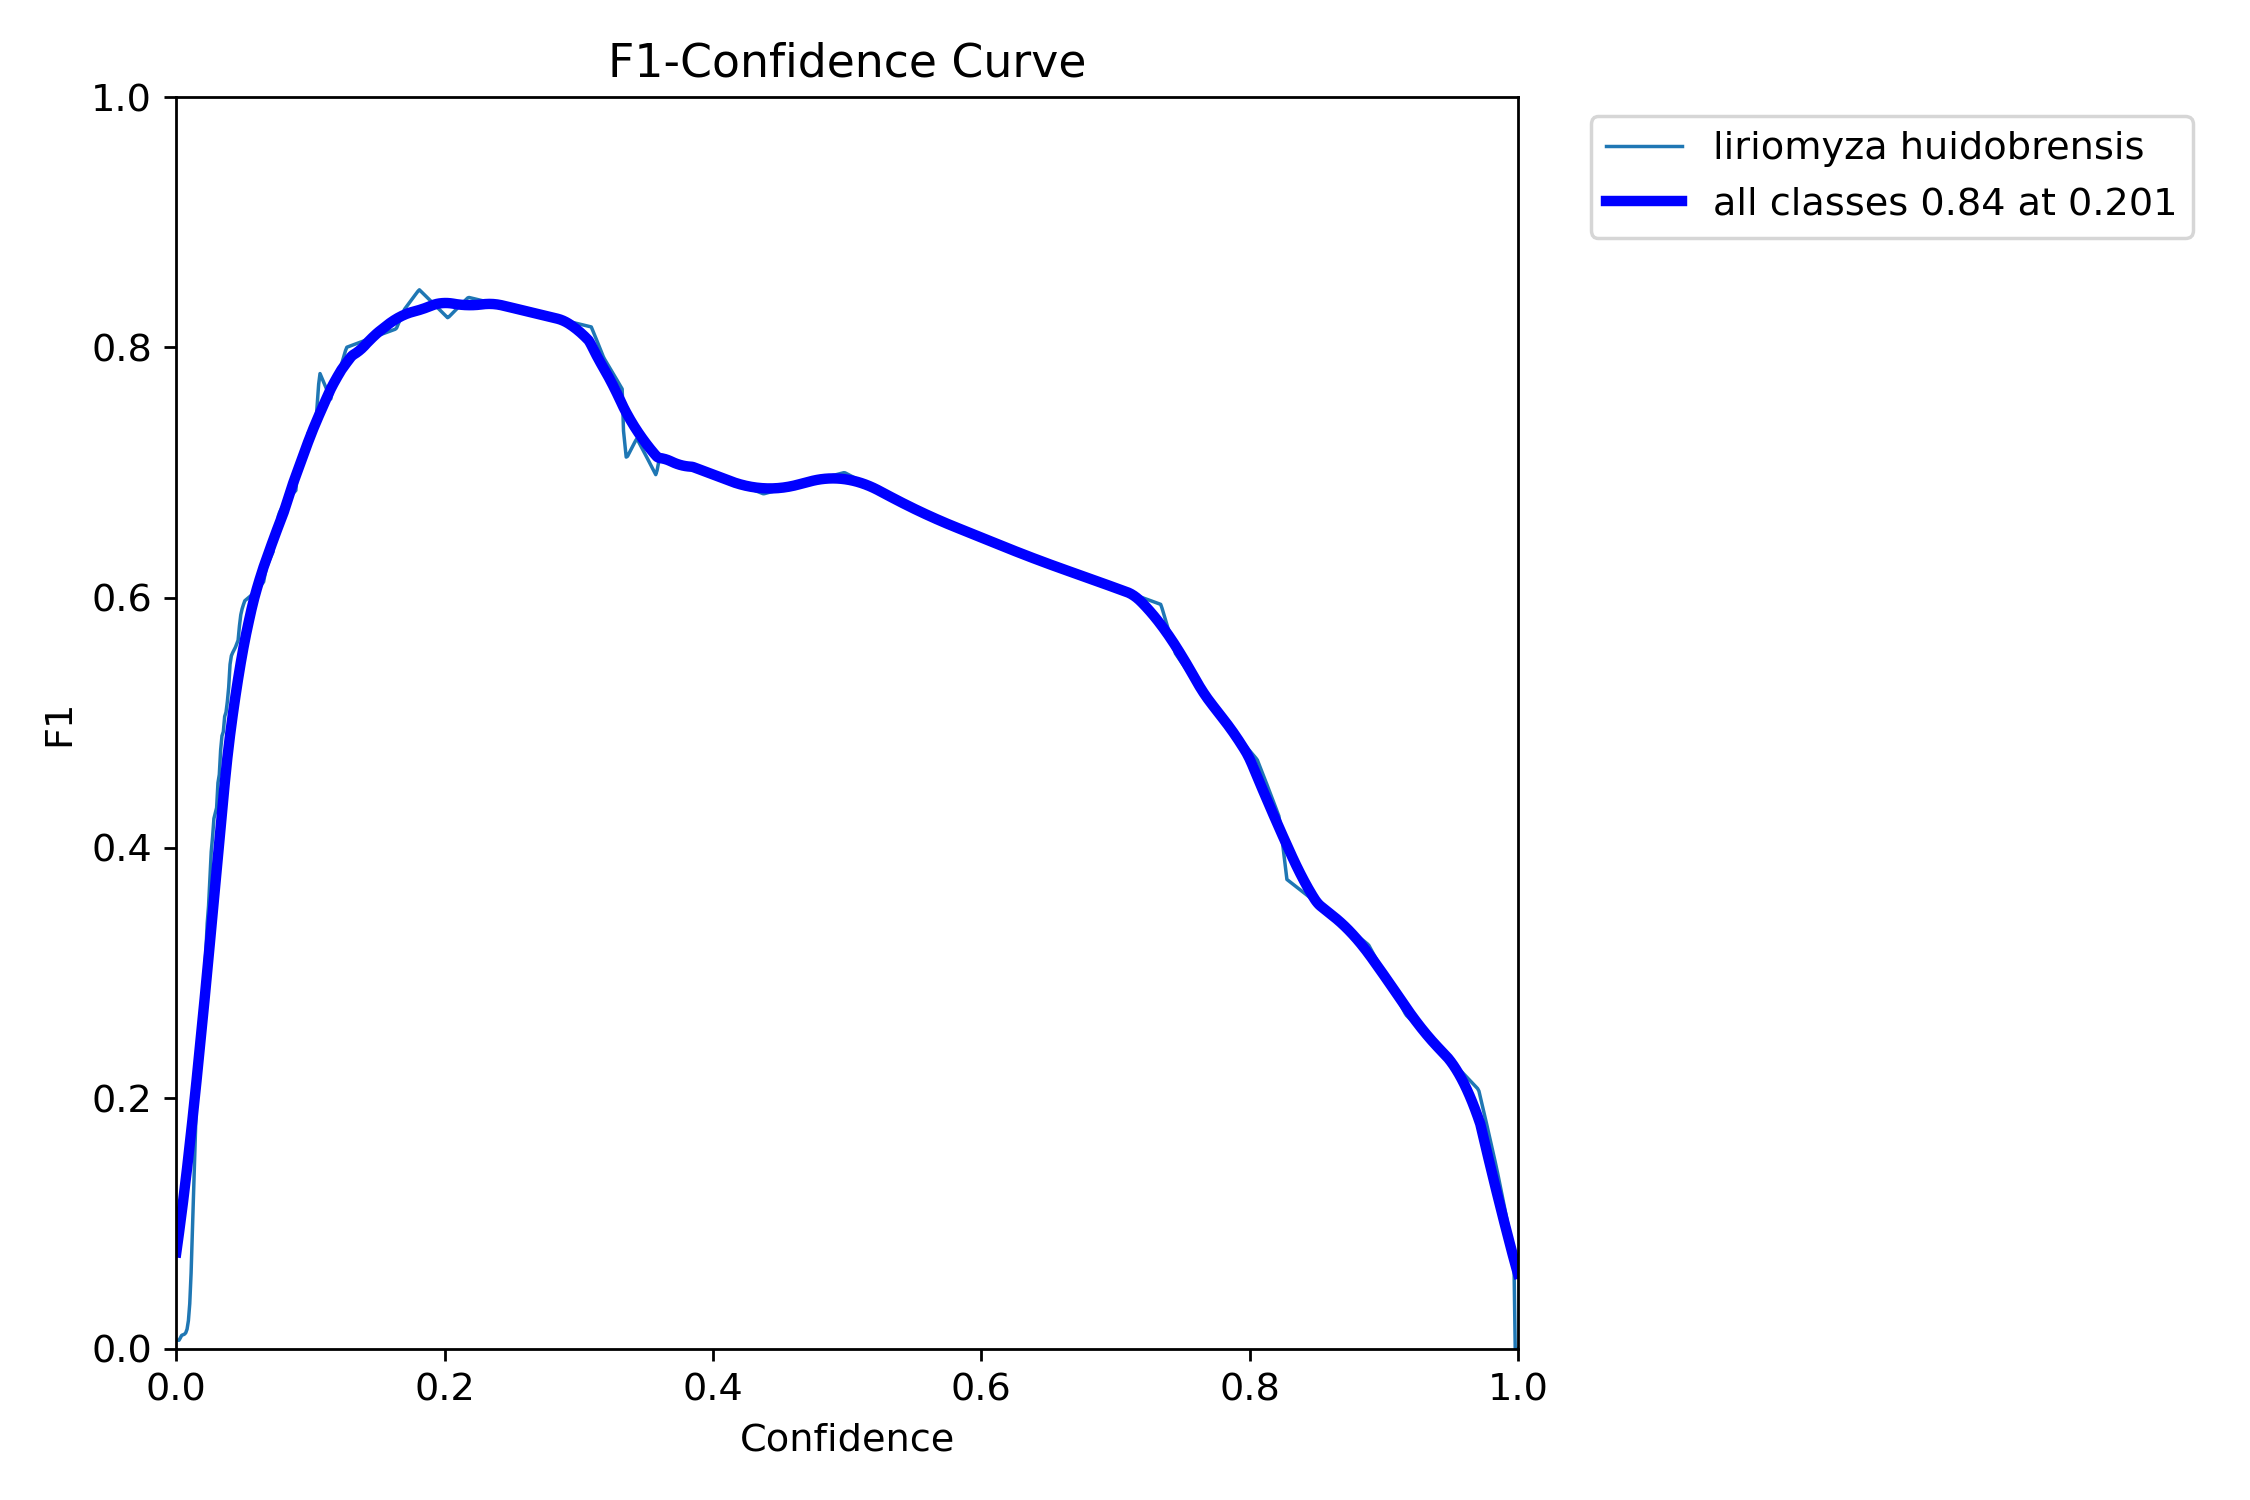

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train/F1_curve.png")
im

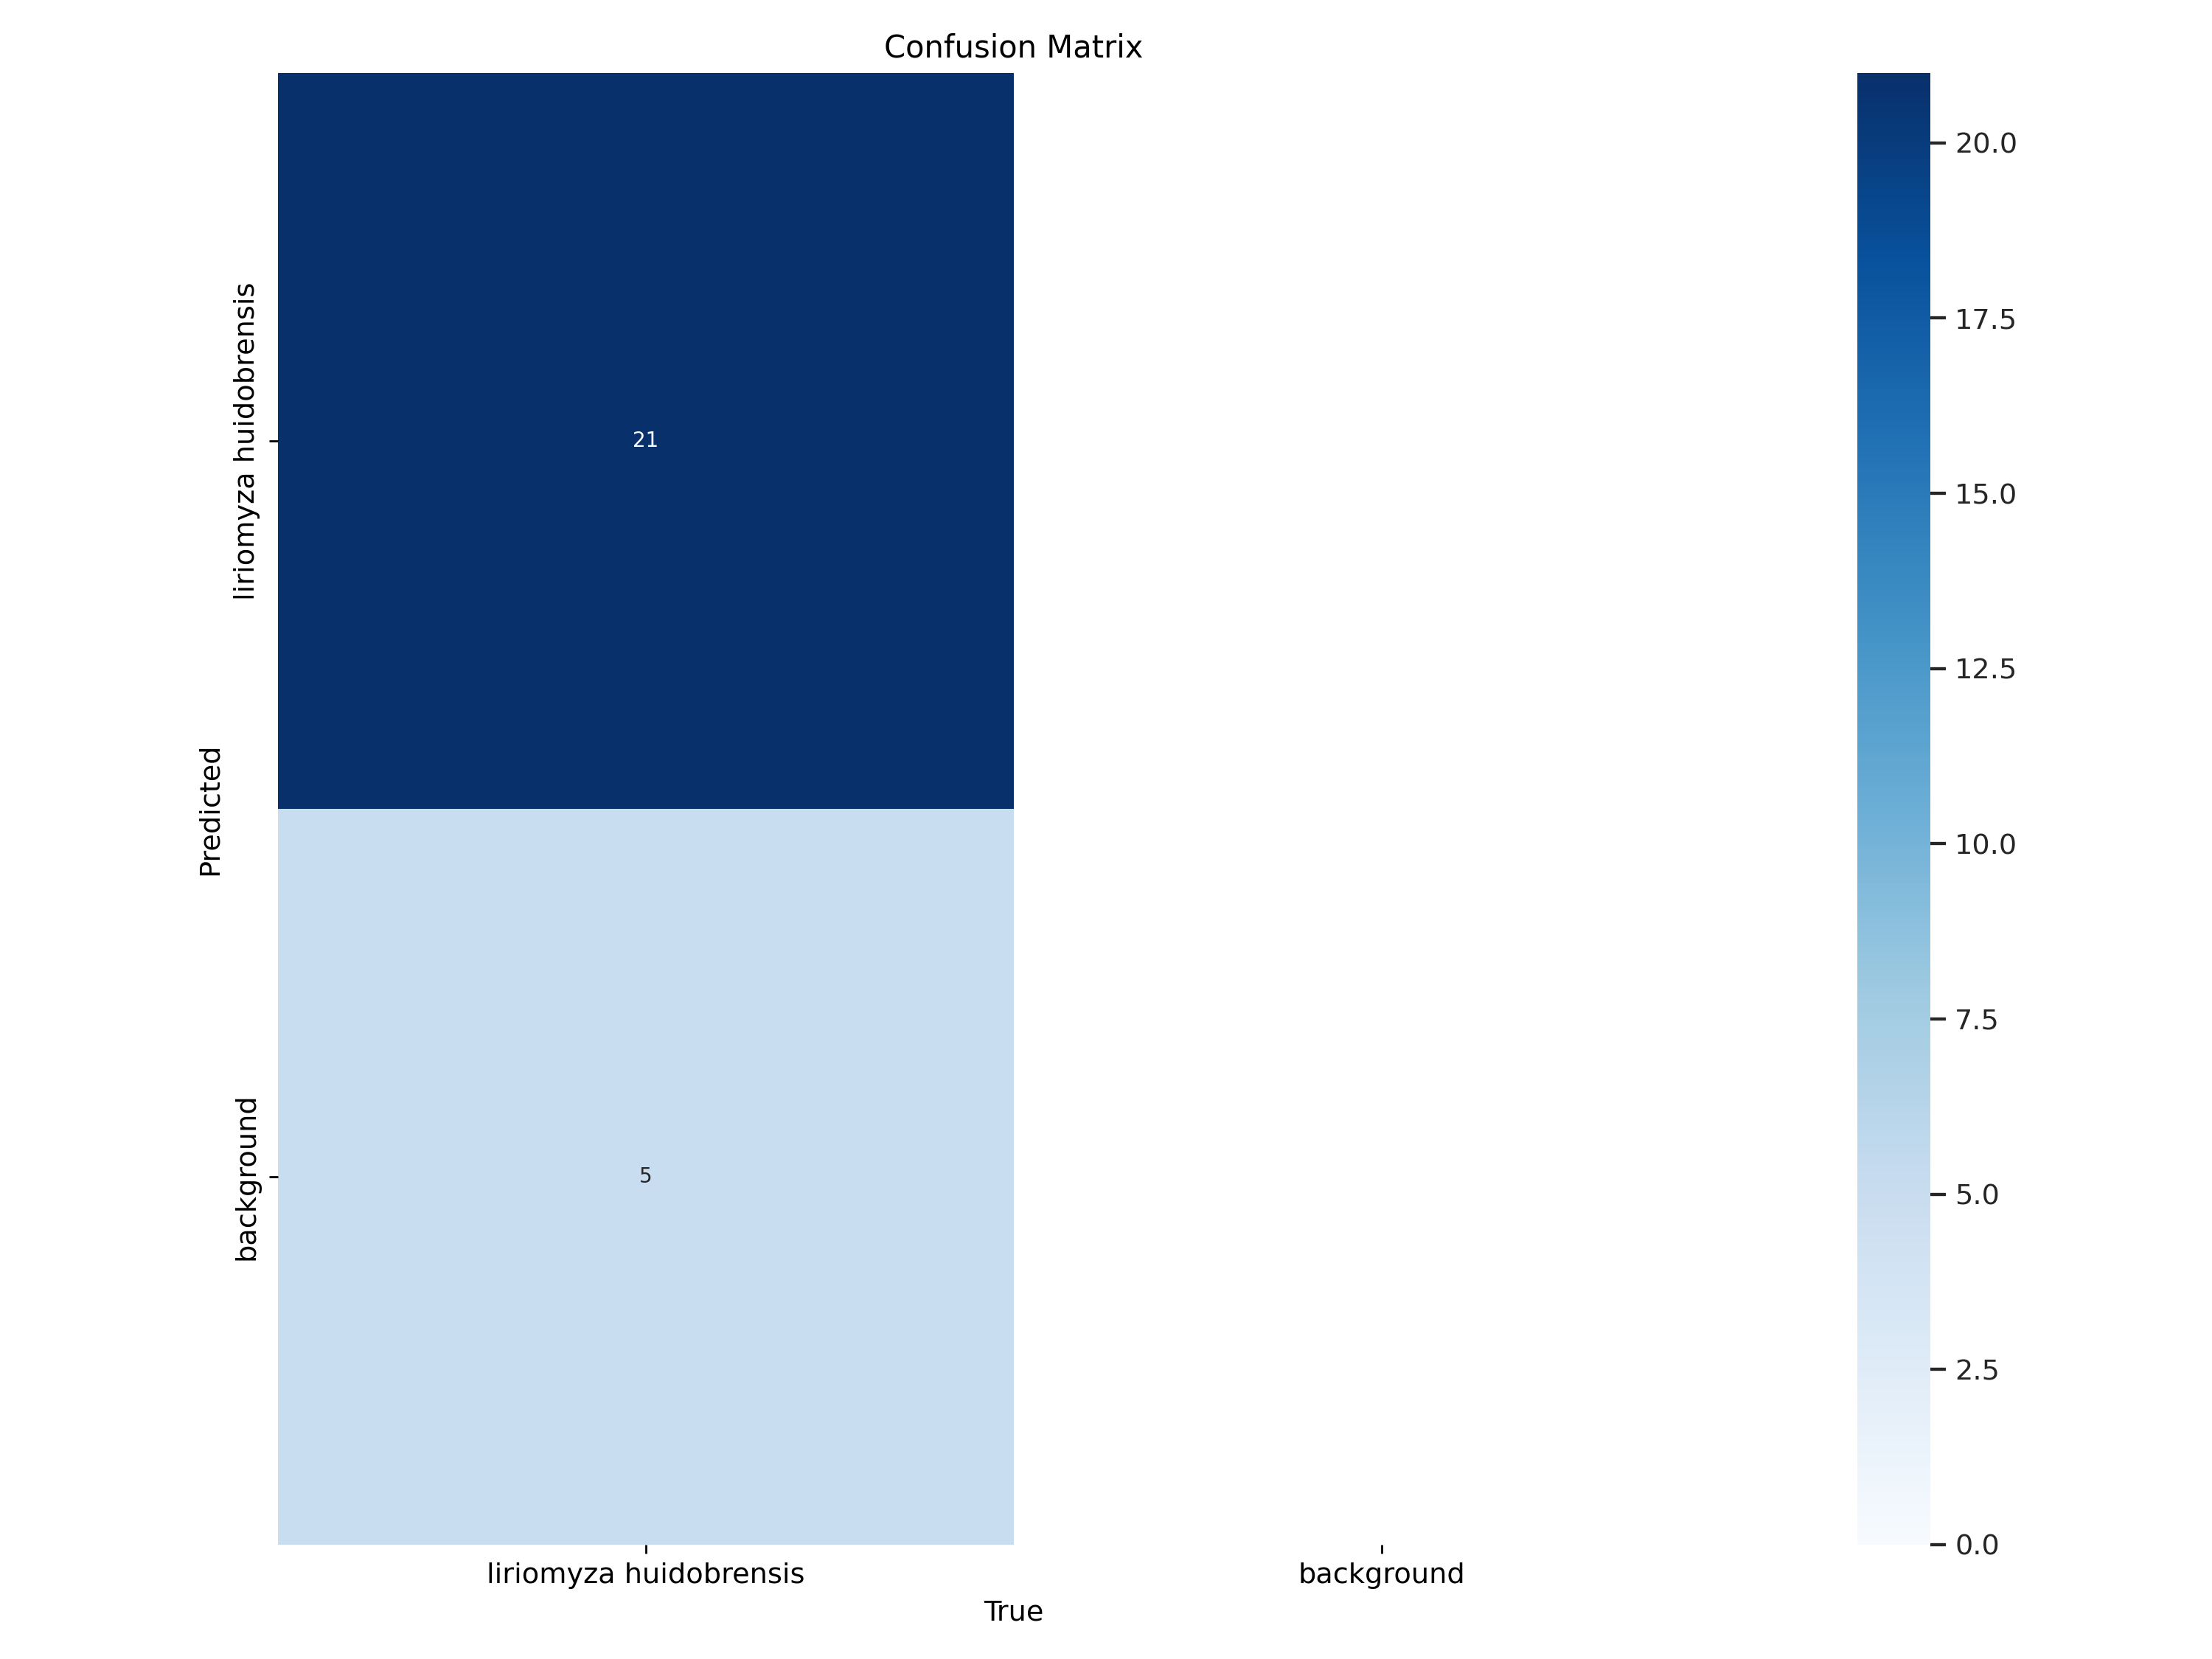

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train/confusion_matrix.png")
im

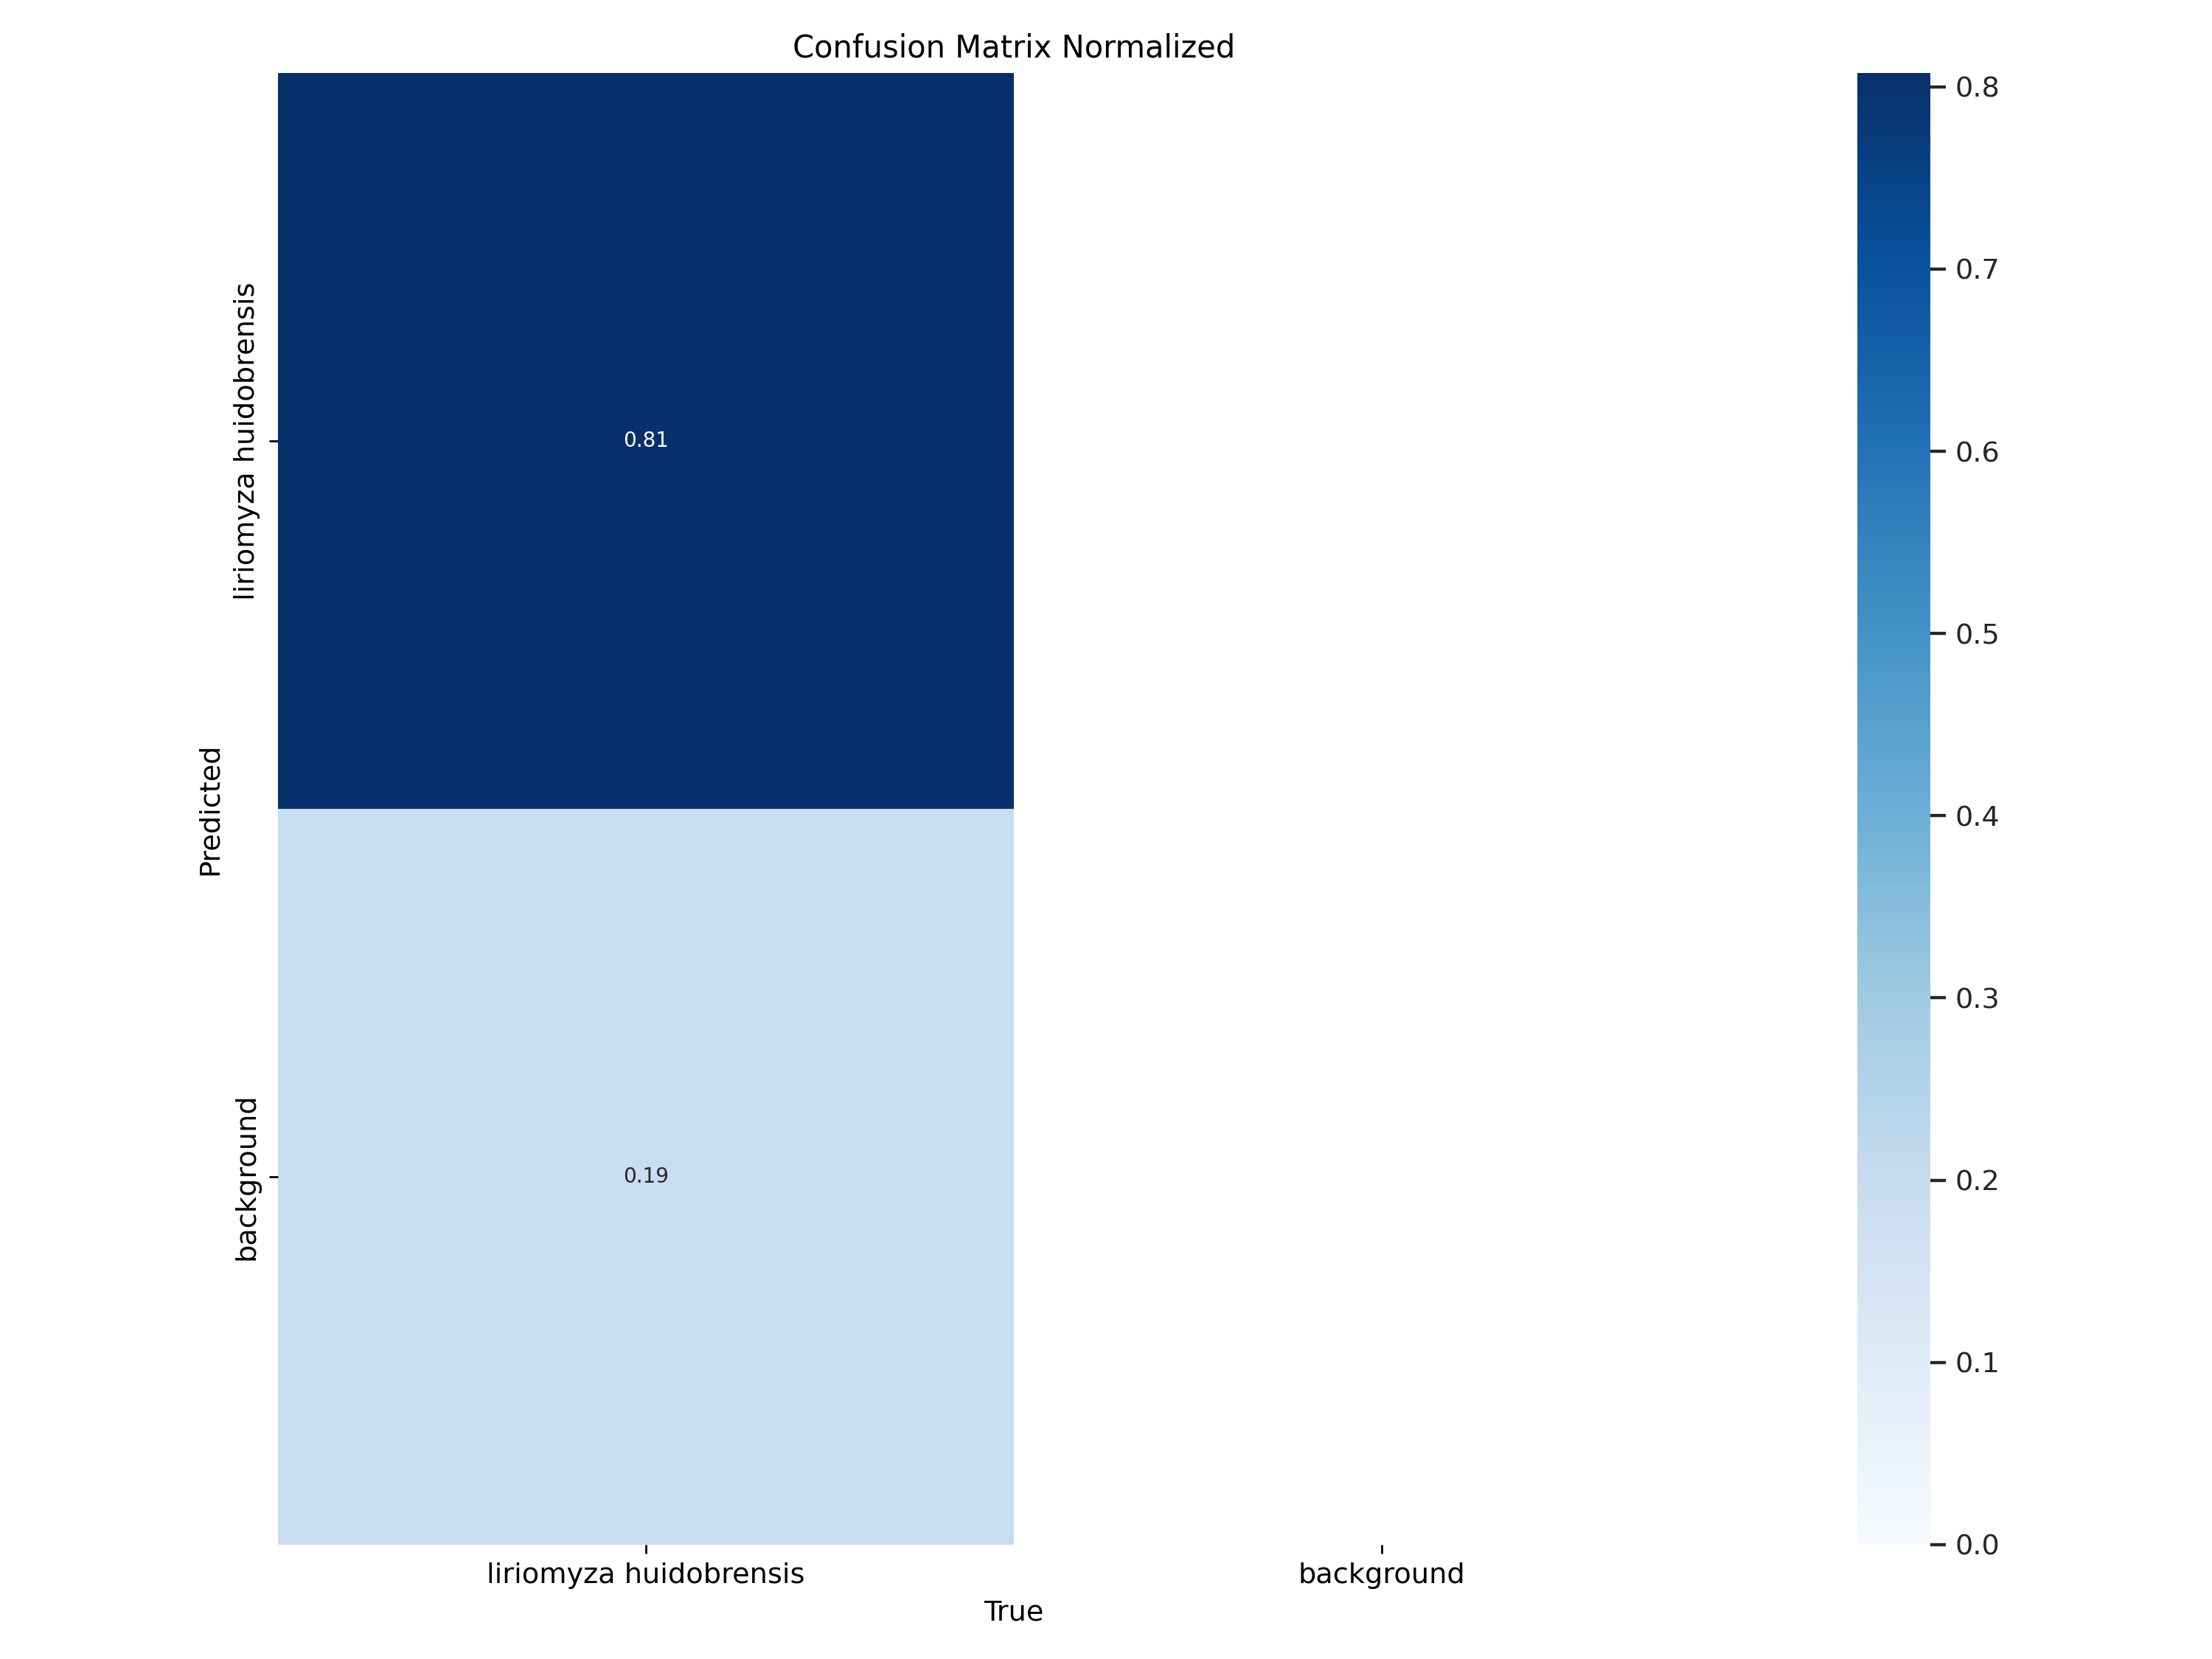

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train/confusion_matrix_normalized.png")
im

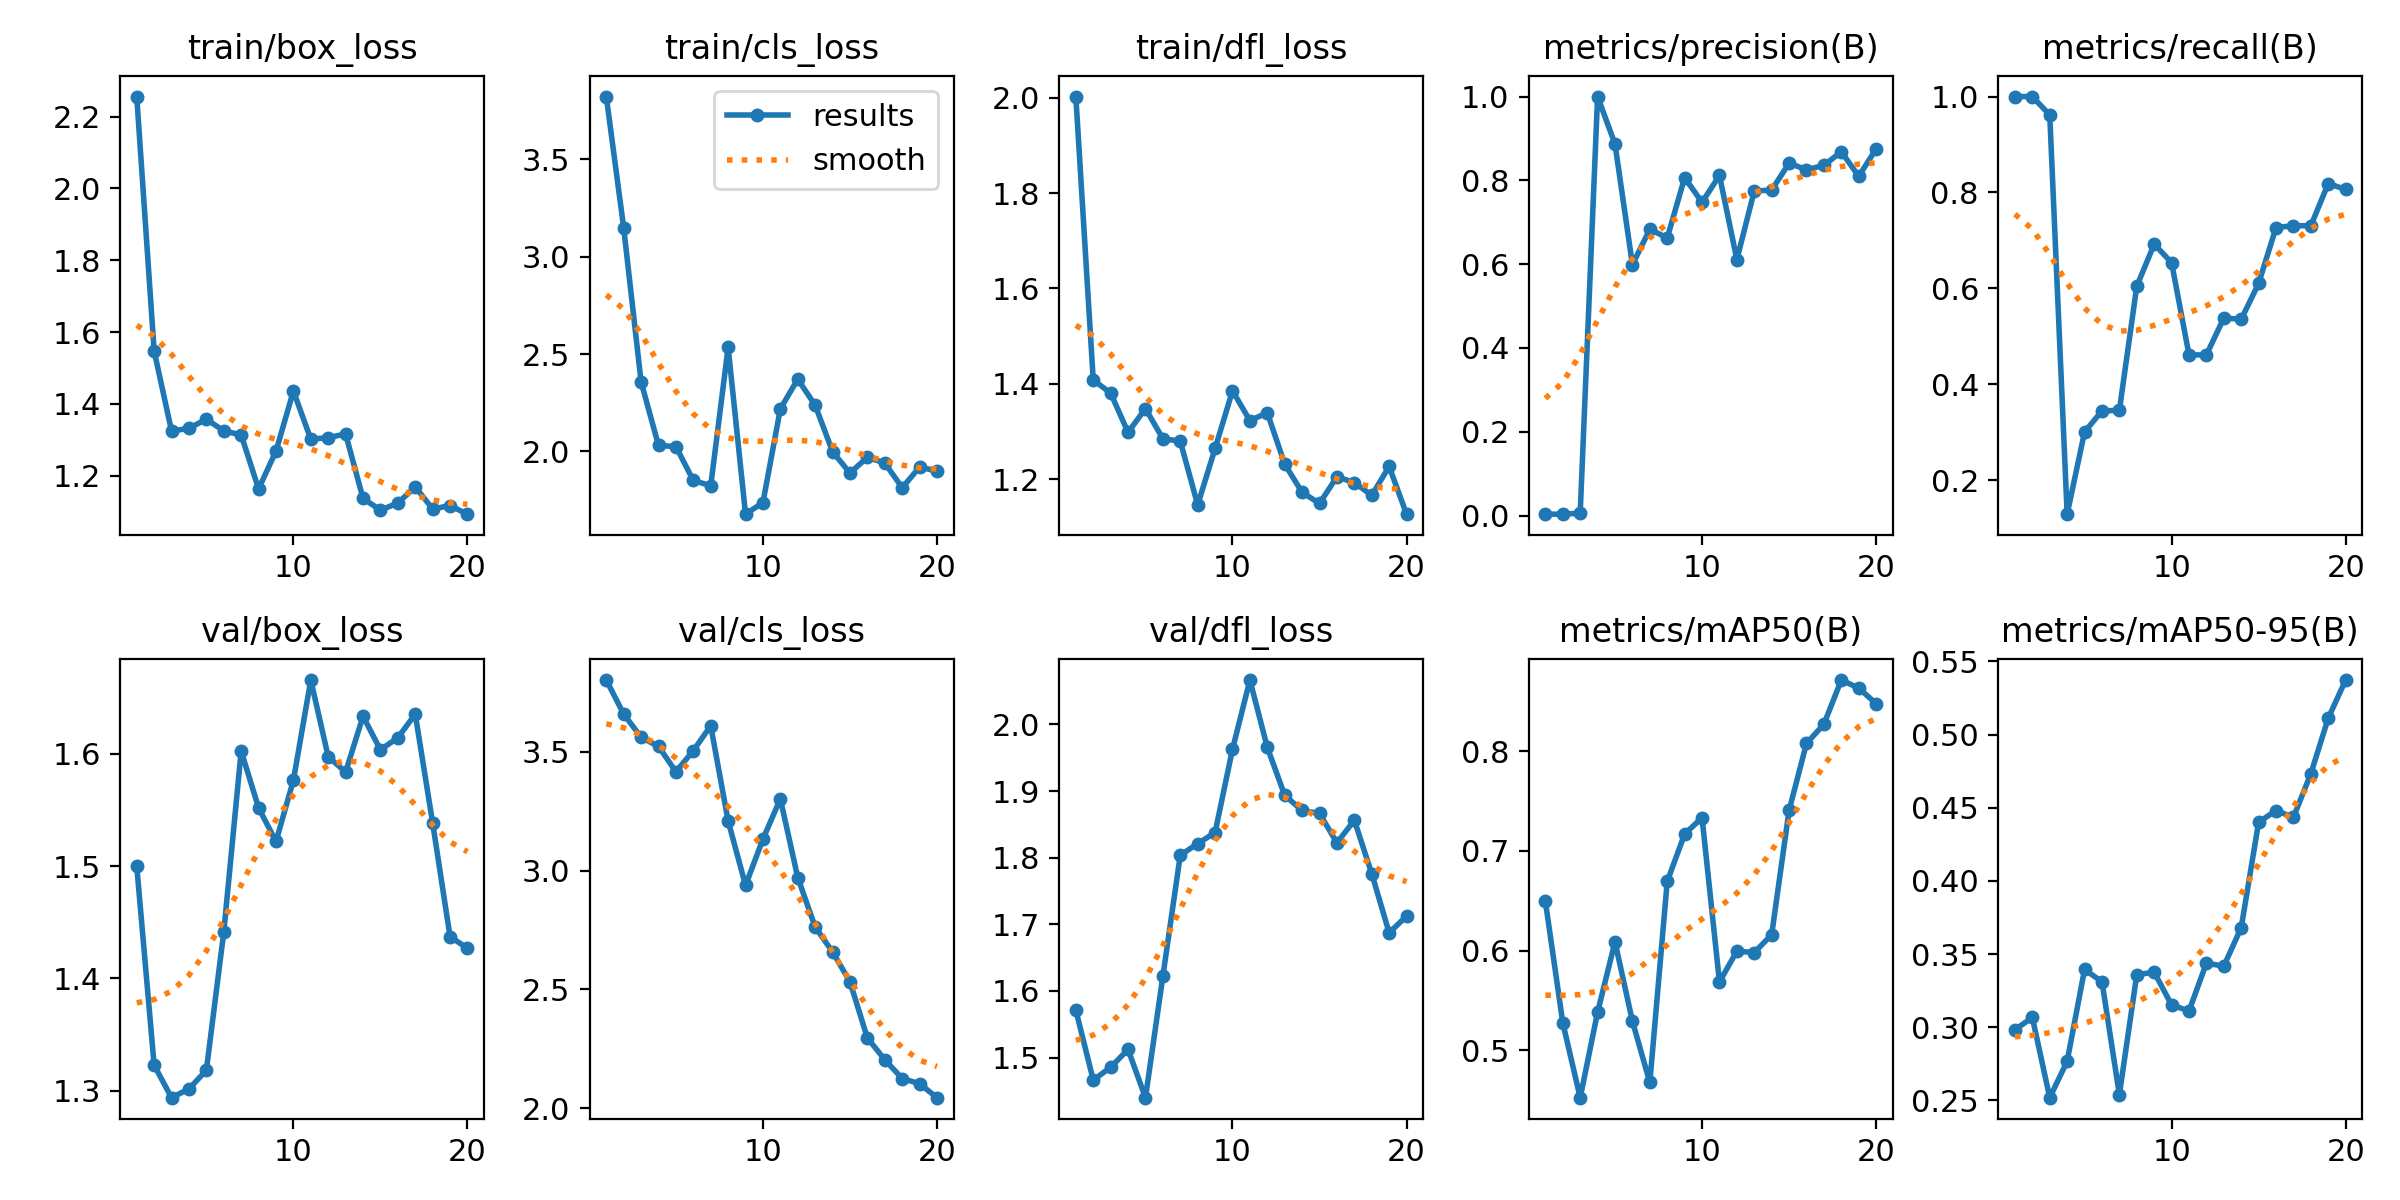

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train/results.png")
im

In [ ]:
model_tr("/content/data/images/test/image_000068.jpg", save = True)


image 1/1 /content/data/images/test/image_000068.jpg: 384x640 2 pectinophora gossypiellas, 108.1ms
Speed: 2.7ms preprocess, 108.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'helicoverpa armigera', 1: 'pectinophora gossypiella'}
 orig_img: array([[[ 27,  49,  60],
         [ 25,  47,  58],
         [ 23,  45,  57],
         ...,
         [193, 191, 183],
         [193, 191, 183],
         [193, 191, 183]],
 
        [[ 27,  49,  60],
         [ 25,  47,  58],
         [ 23,  45,  57],
         ...,
         [193, 191, 183],
         [193, 191, 183],
         [193, 191, 183]],
 
        [[ 30,  52,  63],
         [ 29,  51,  62],
         [ 27,  49,  61],
         ...,
         [193, 191, 183],
         [193, 191, 183],
         [193, 191, 183]],
 
        ...,
 
        [[ 10,  21,  25],
         [ 12,  23,  27],
         [ 14,  26,  30],
         ...,
         [158, 160, 161],
         [157, 159, 160],
         [157, 159, 160]],
 
        [[ 13,  23,  30],
         [ 13,  23,  30

In [ ]:
from ultralytics import YOLO

model_tr = YOLO('/content/runs/detect/train/weights/best.pt')
model_tr.val()

Ultralytics YOLOv8.0.214 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/LYROMIZAR-PEST-DETECTION/test/labels.cache... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


                   all         25         26      0.875      0.807      0.848      0.535
Speed: 0.3ms preprocess, 36.9ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7af990dfa9e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
from ultralytics import YOLO

model_tr = YOLO('/content/finetuned_yolov8n.pt')
model_tr.val(split = "test")

FileNotFoundError: ignored

#Entrenamiento del modelo YOLOv8s para deteccion de pestes de algodon

In [ ]:
from ultralytics import YOLO

model_tr = YOLO('yolov8s.yaml').load('yolov8s.pt')
model_tr.train(
    data='data.yaml',
    epochs=20,
    imgsz=21,
    batch = 32)


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [ ]:
model_tr.val()
model_tr.predict(source="/content/data/images/test/image_000068.jpg")  # predict on an image
model_tr.export()  # export the model to ONNX format

Ultralytics YOLOv8.0.125 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8s summary (fused): 168 layers, 11126358 parameters, 0 gradients
val: Scanning /content/data/labels/val.cache... 3086 images, 1394 backgrounds, 0 corrupt: 100%|██████████| 3086/3086 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   3%|▎         | 3/97 [00:27<15:16,  9.75s/it]WARNING ⚠️ NMS time limit 2.100s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [02:03<00:00,  1.28s/it]
                   all       3086      42507      0.861      0.734      0.787      0.514
  helicoverpa armigera       3086       1400        0.9       0.77      0.821      0.617
pectinophora gossypiella       3086      41107      0.823      0.697      0.753      0.412
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect

'runs/detect/train3/weights/best.torchscript'

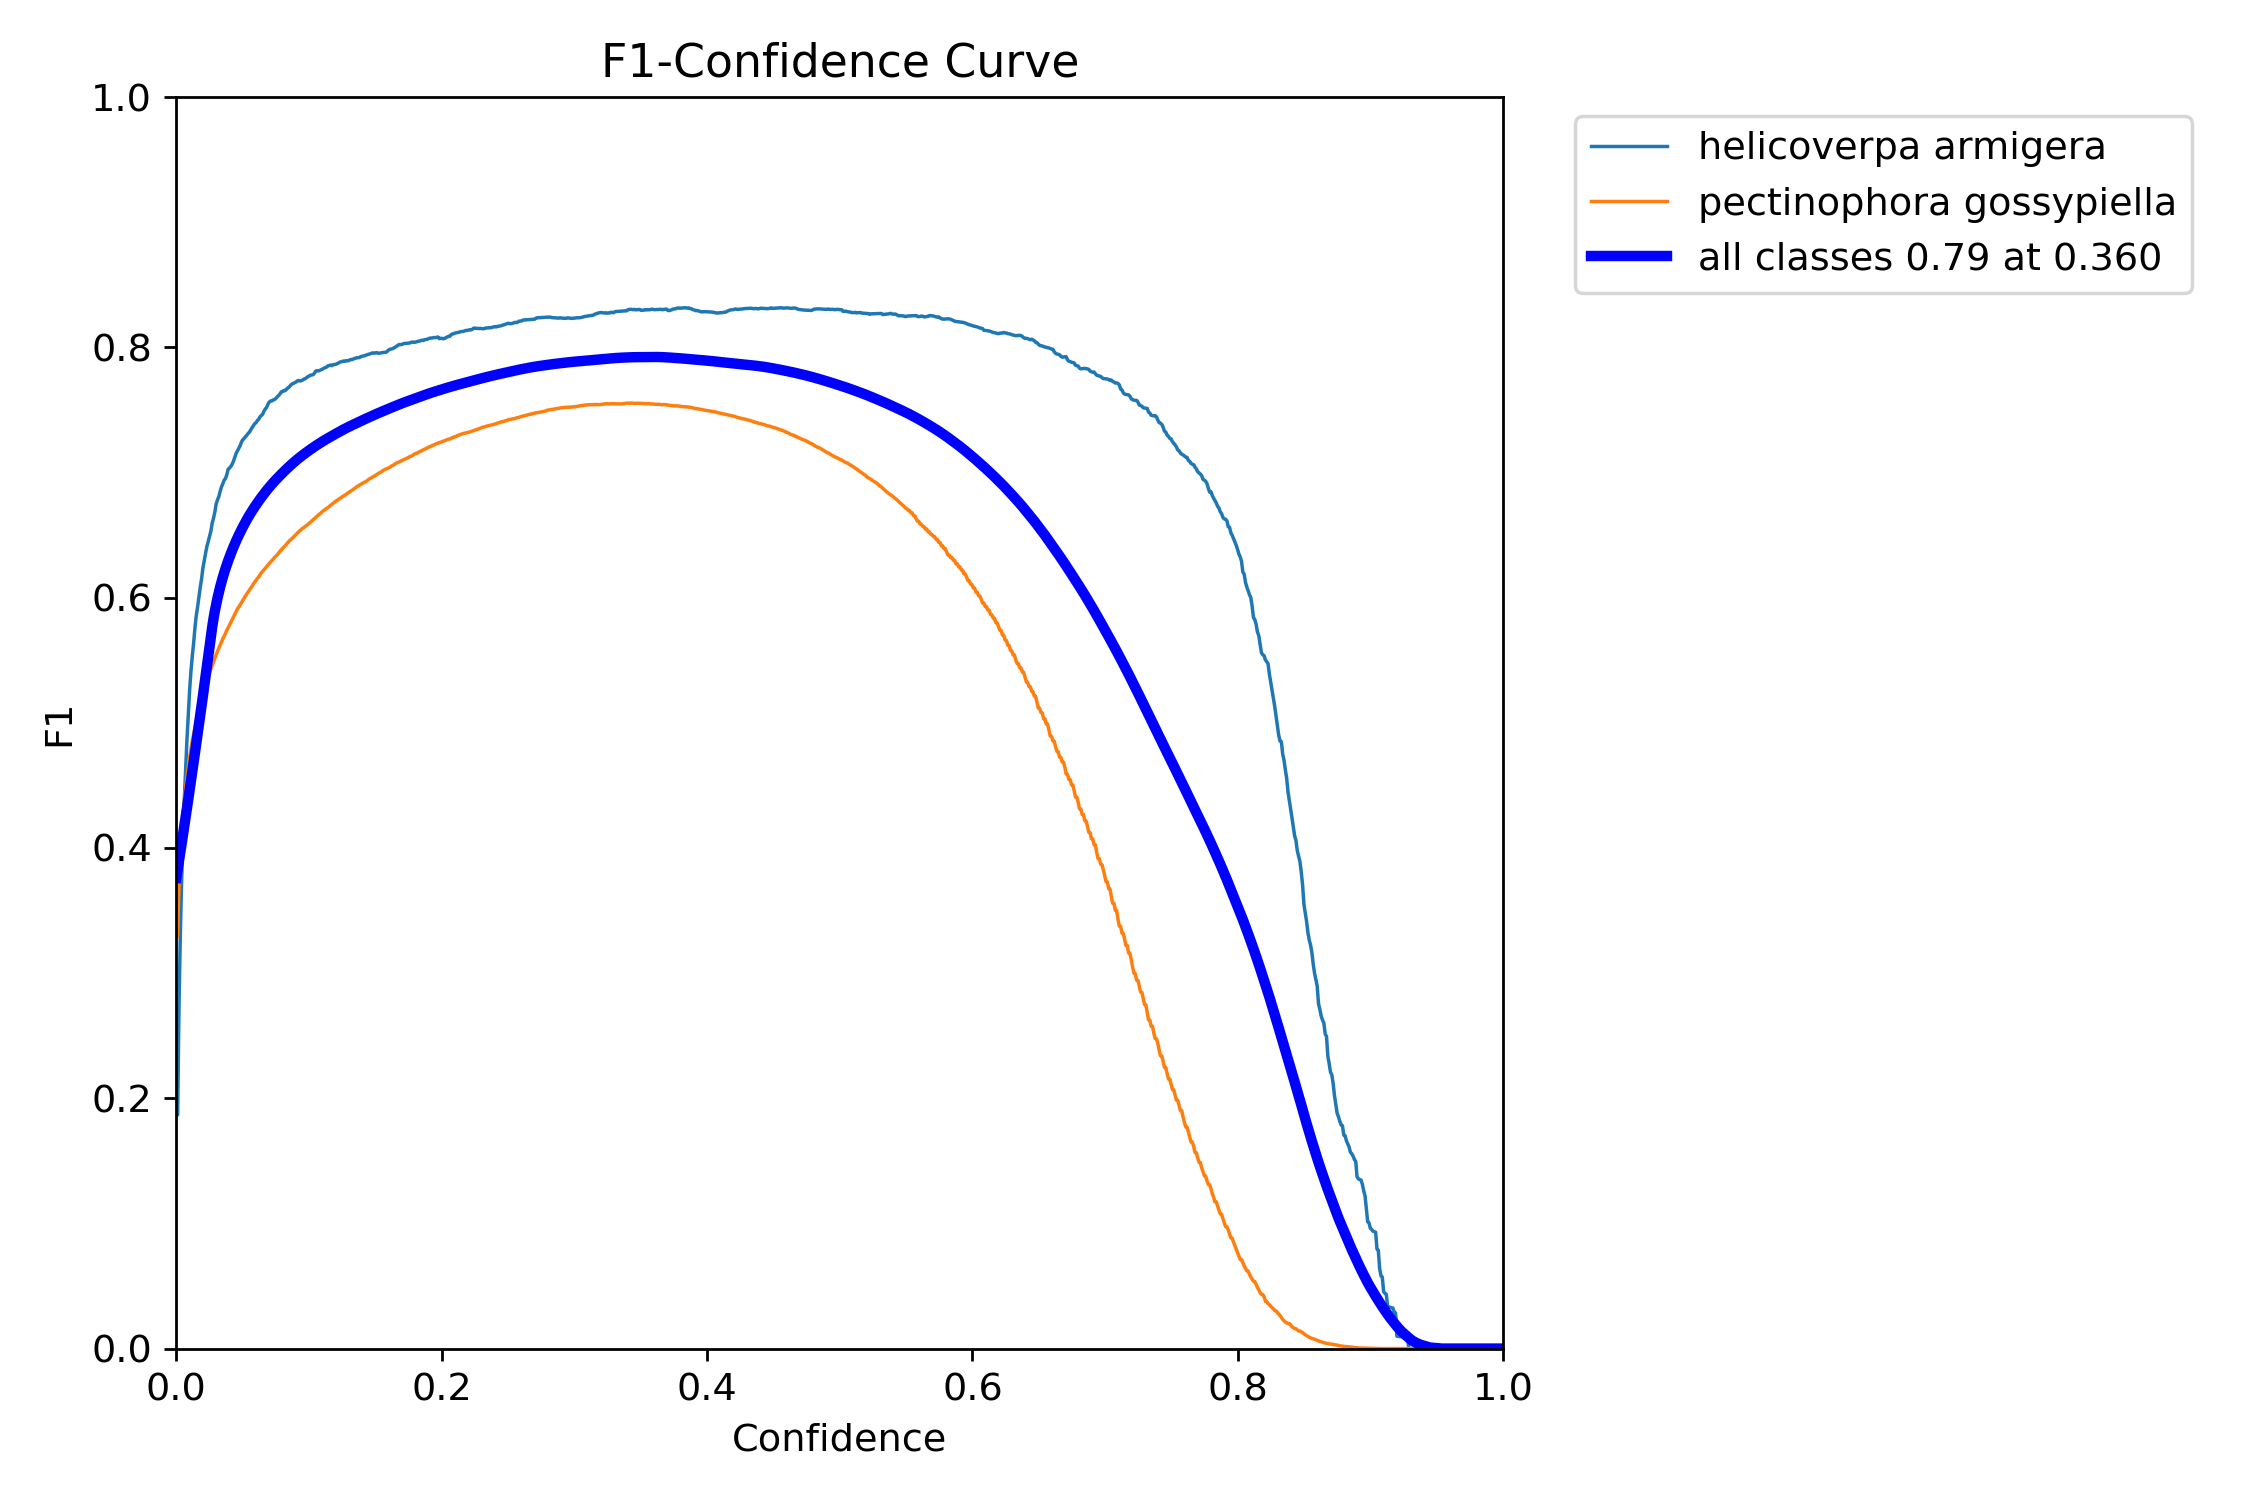

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train3/F1_curve.png")
im.show()

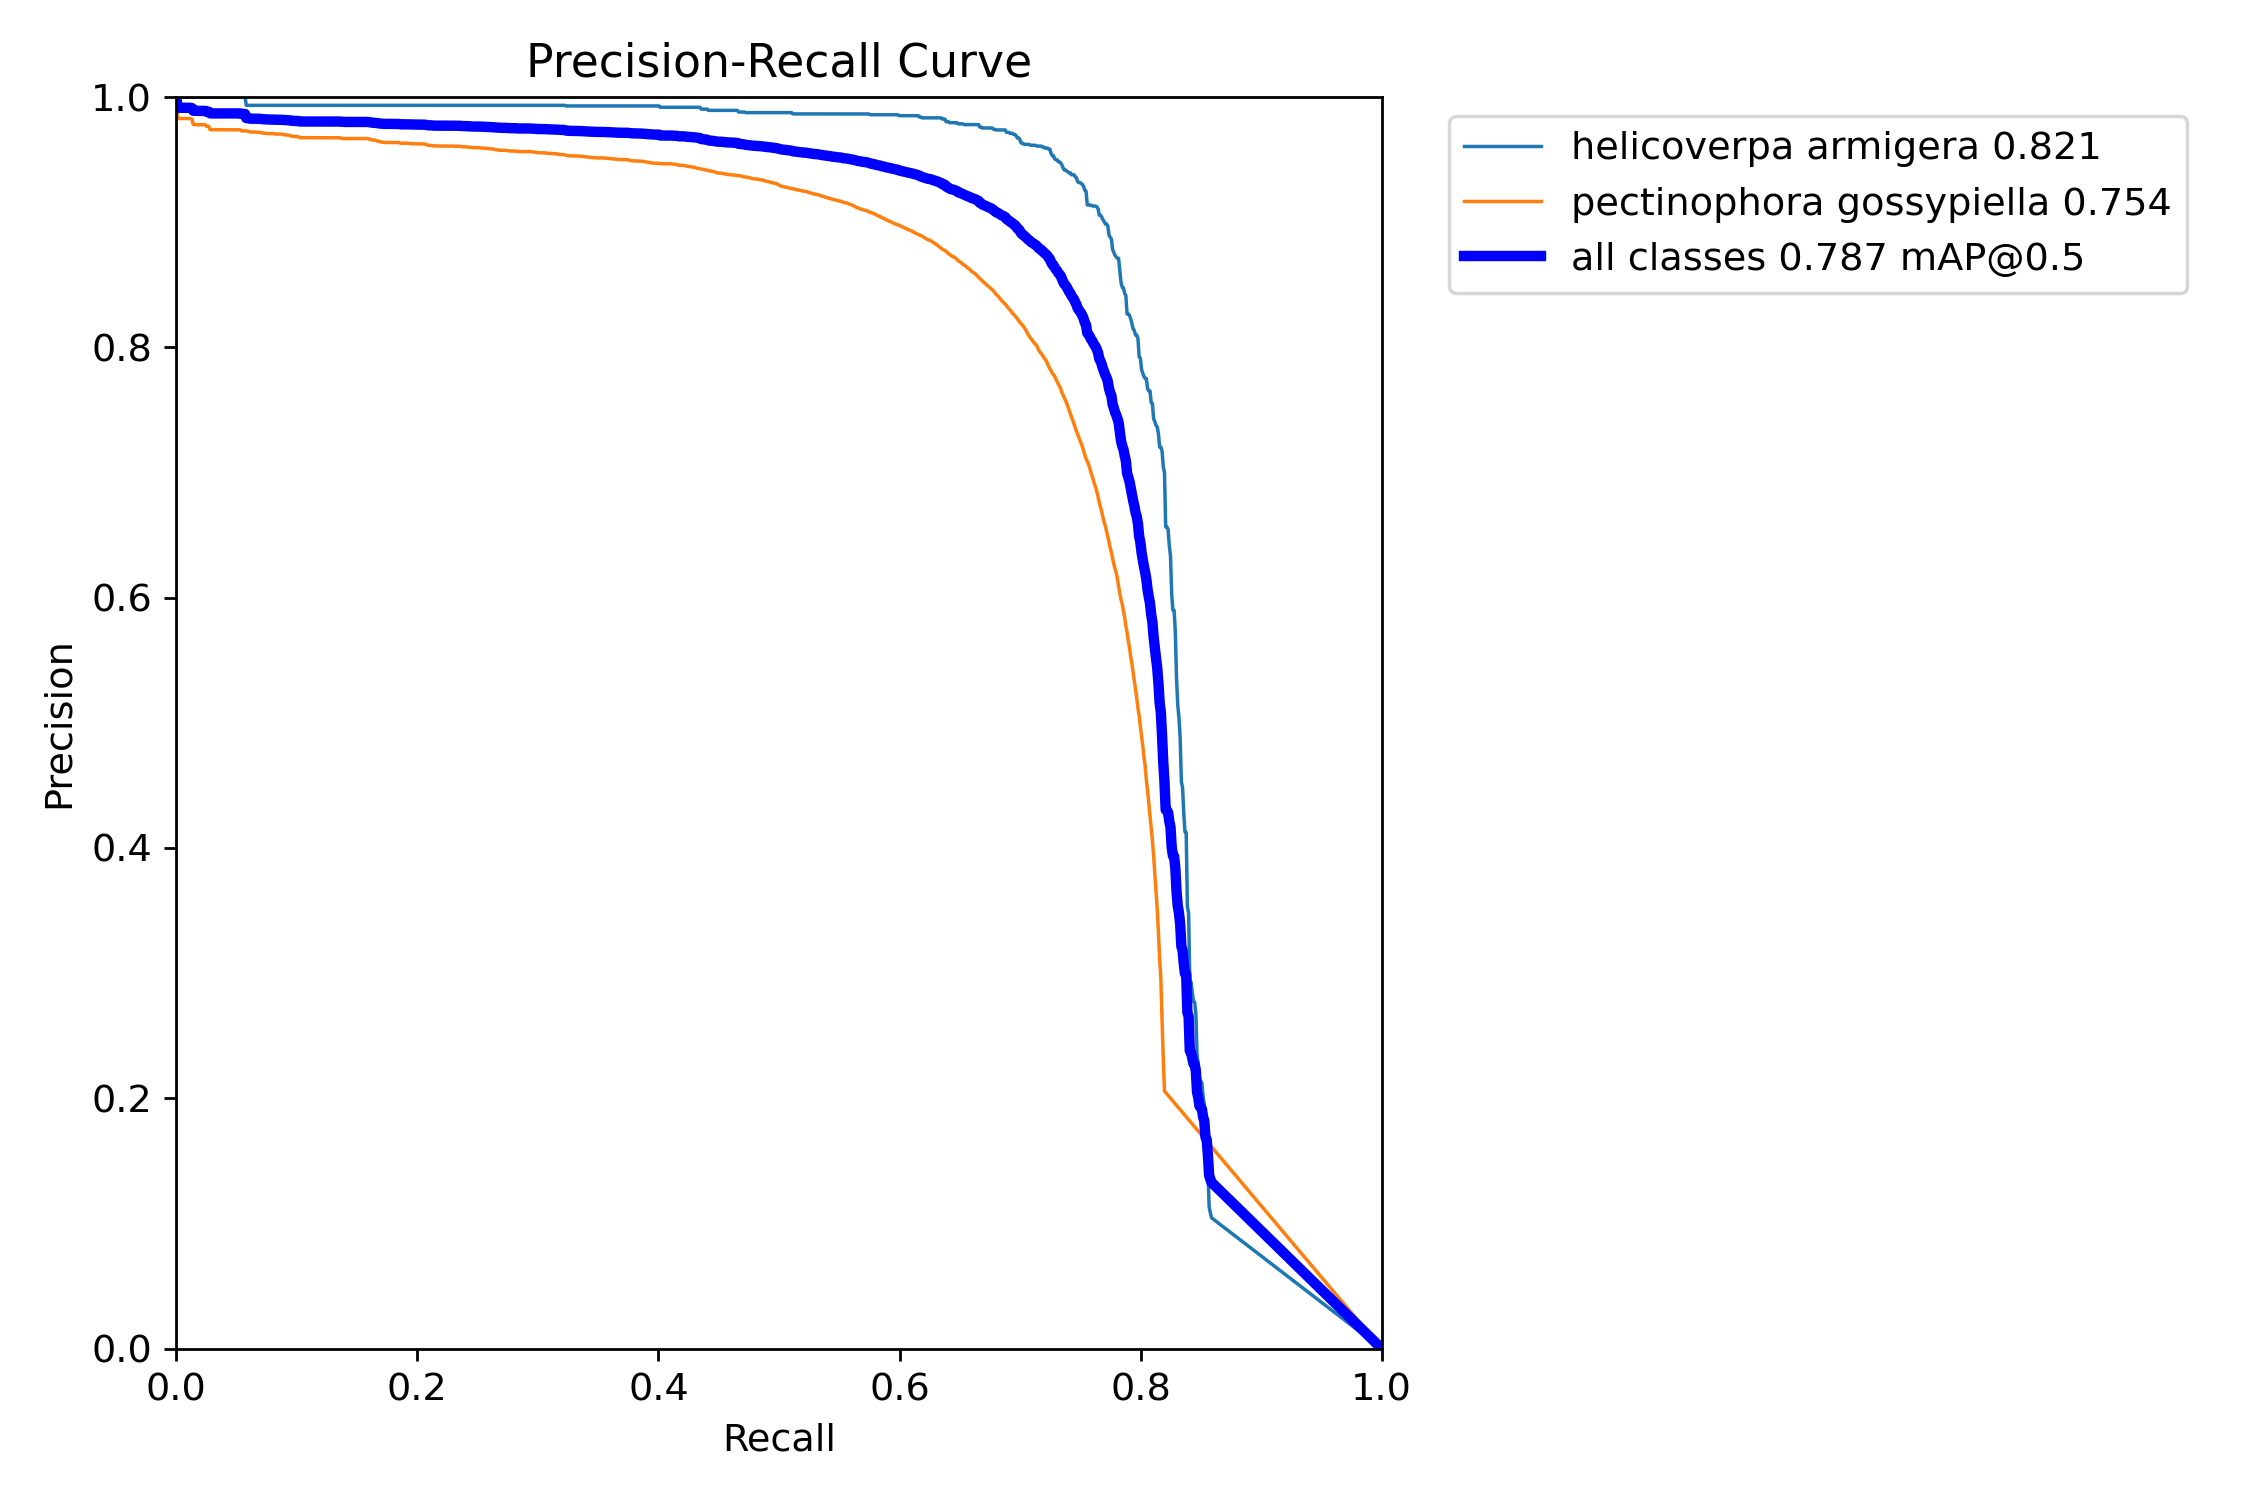

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train3/PR_curve.png")
im.show()

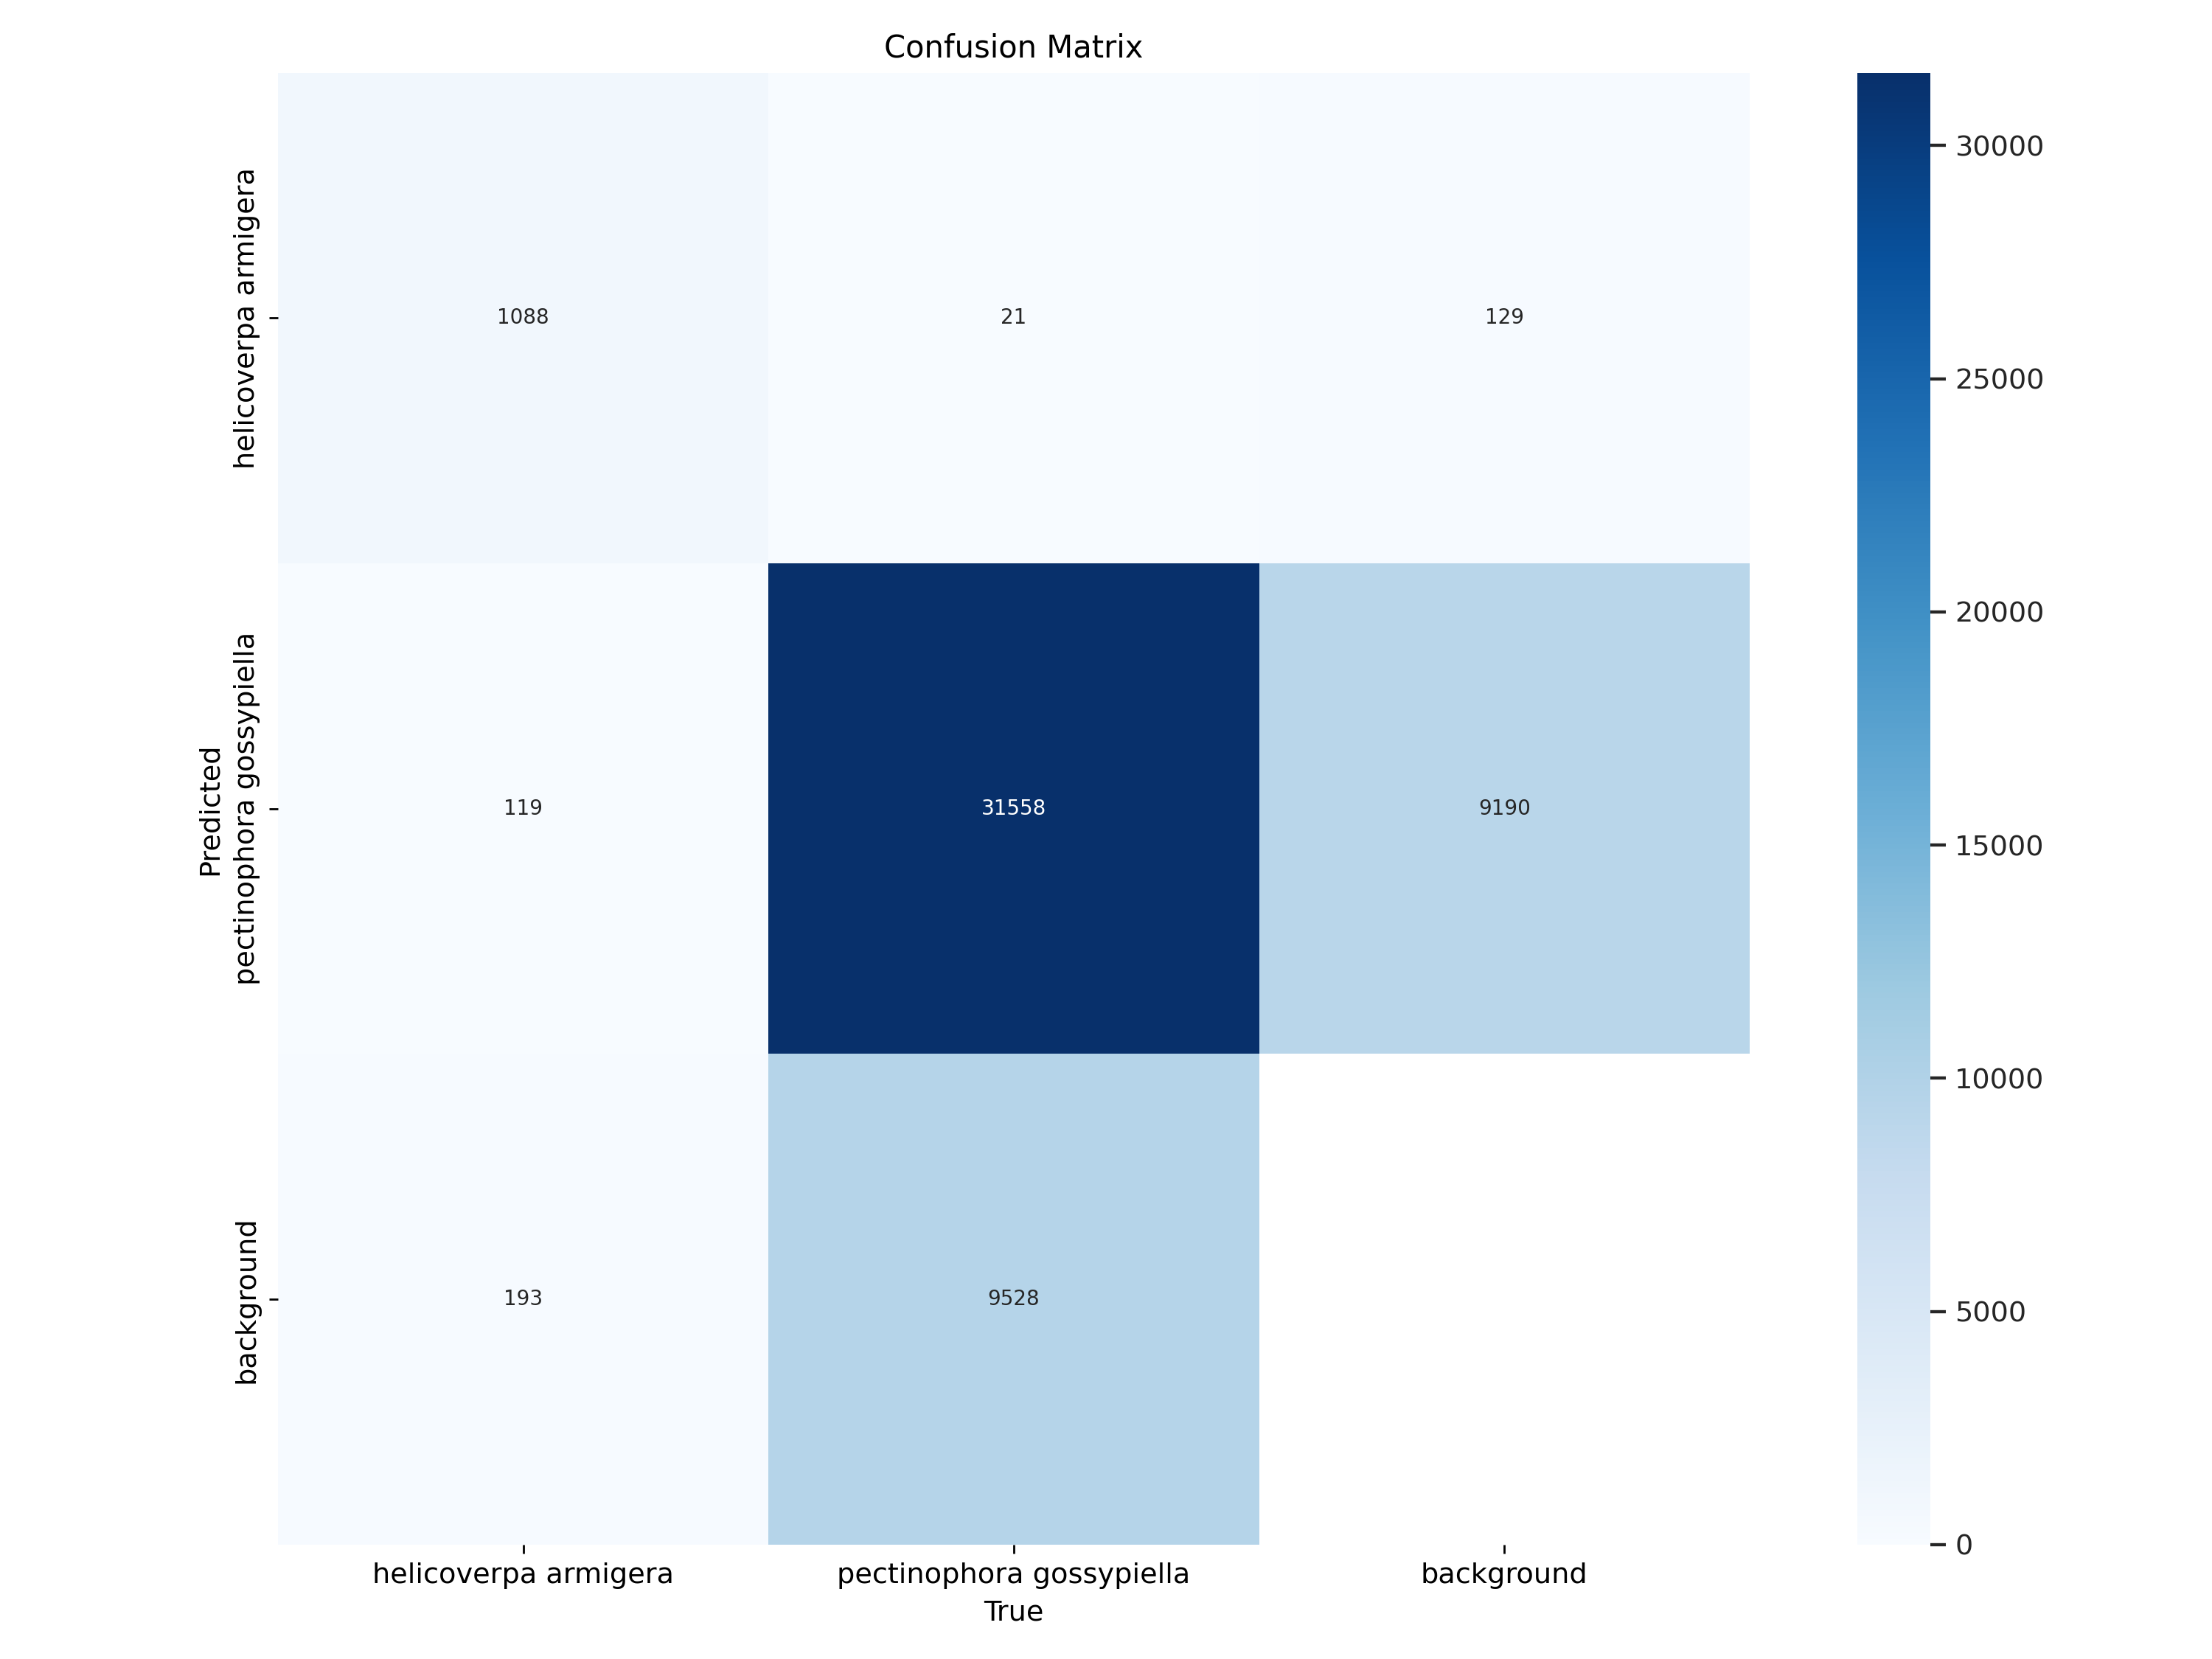

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train3/confusion_matrix.png")
im.show()

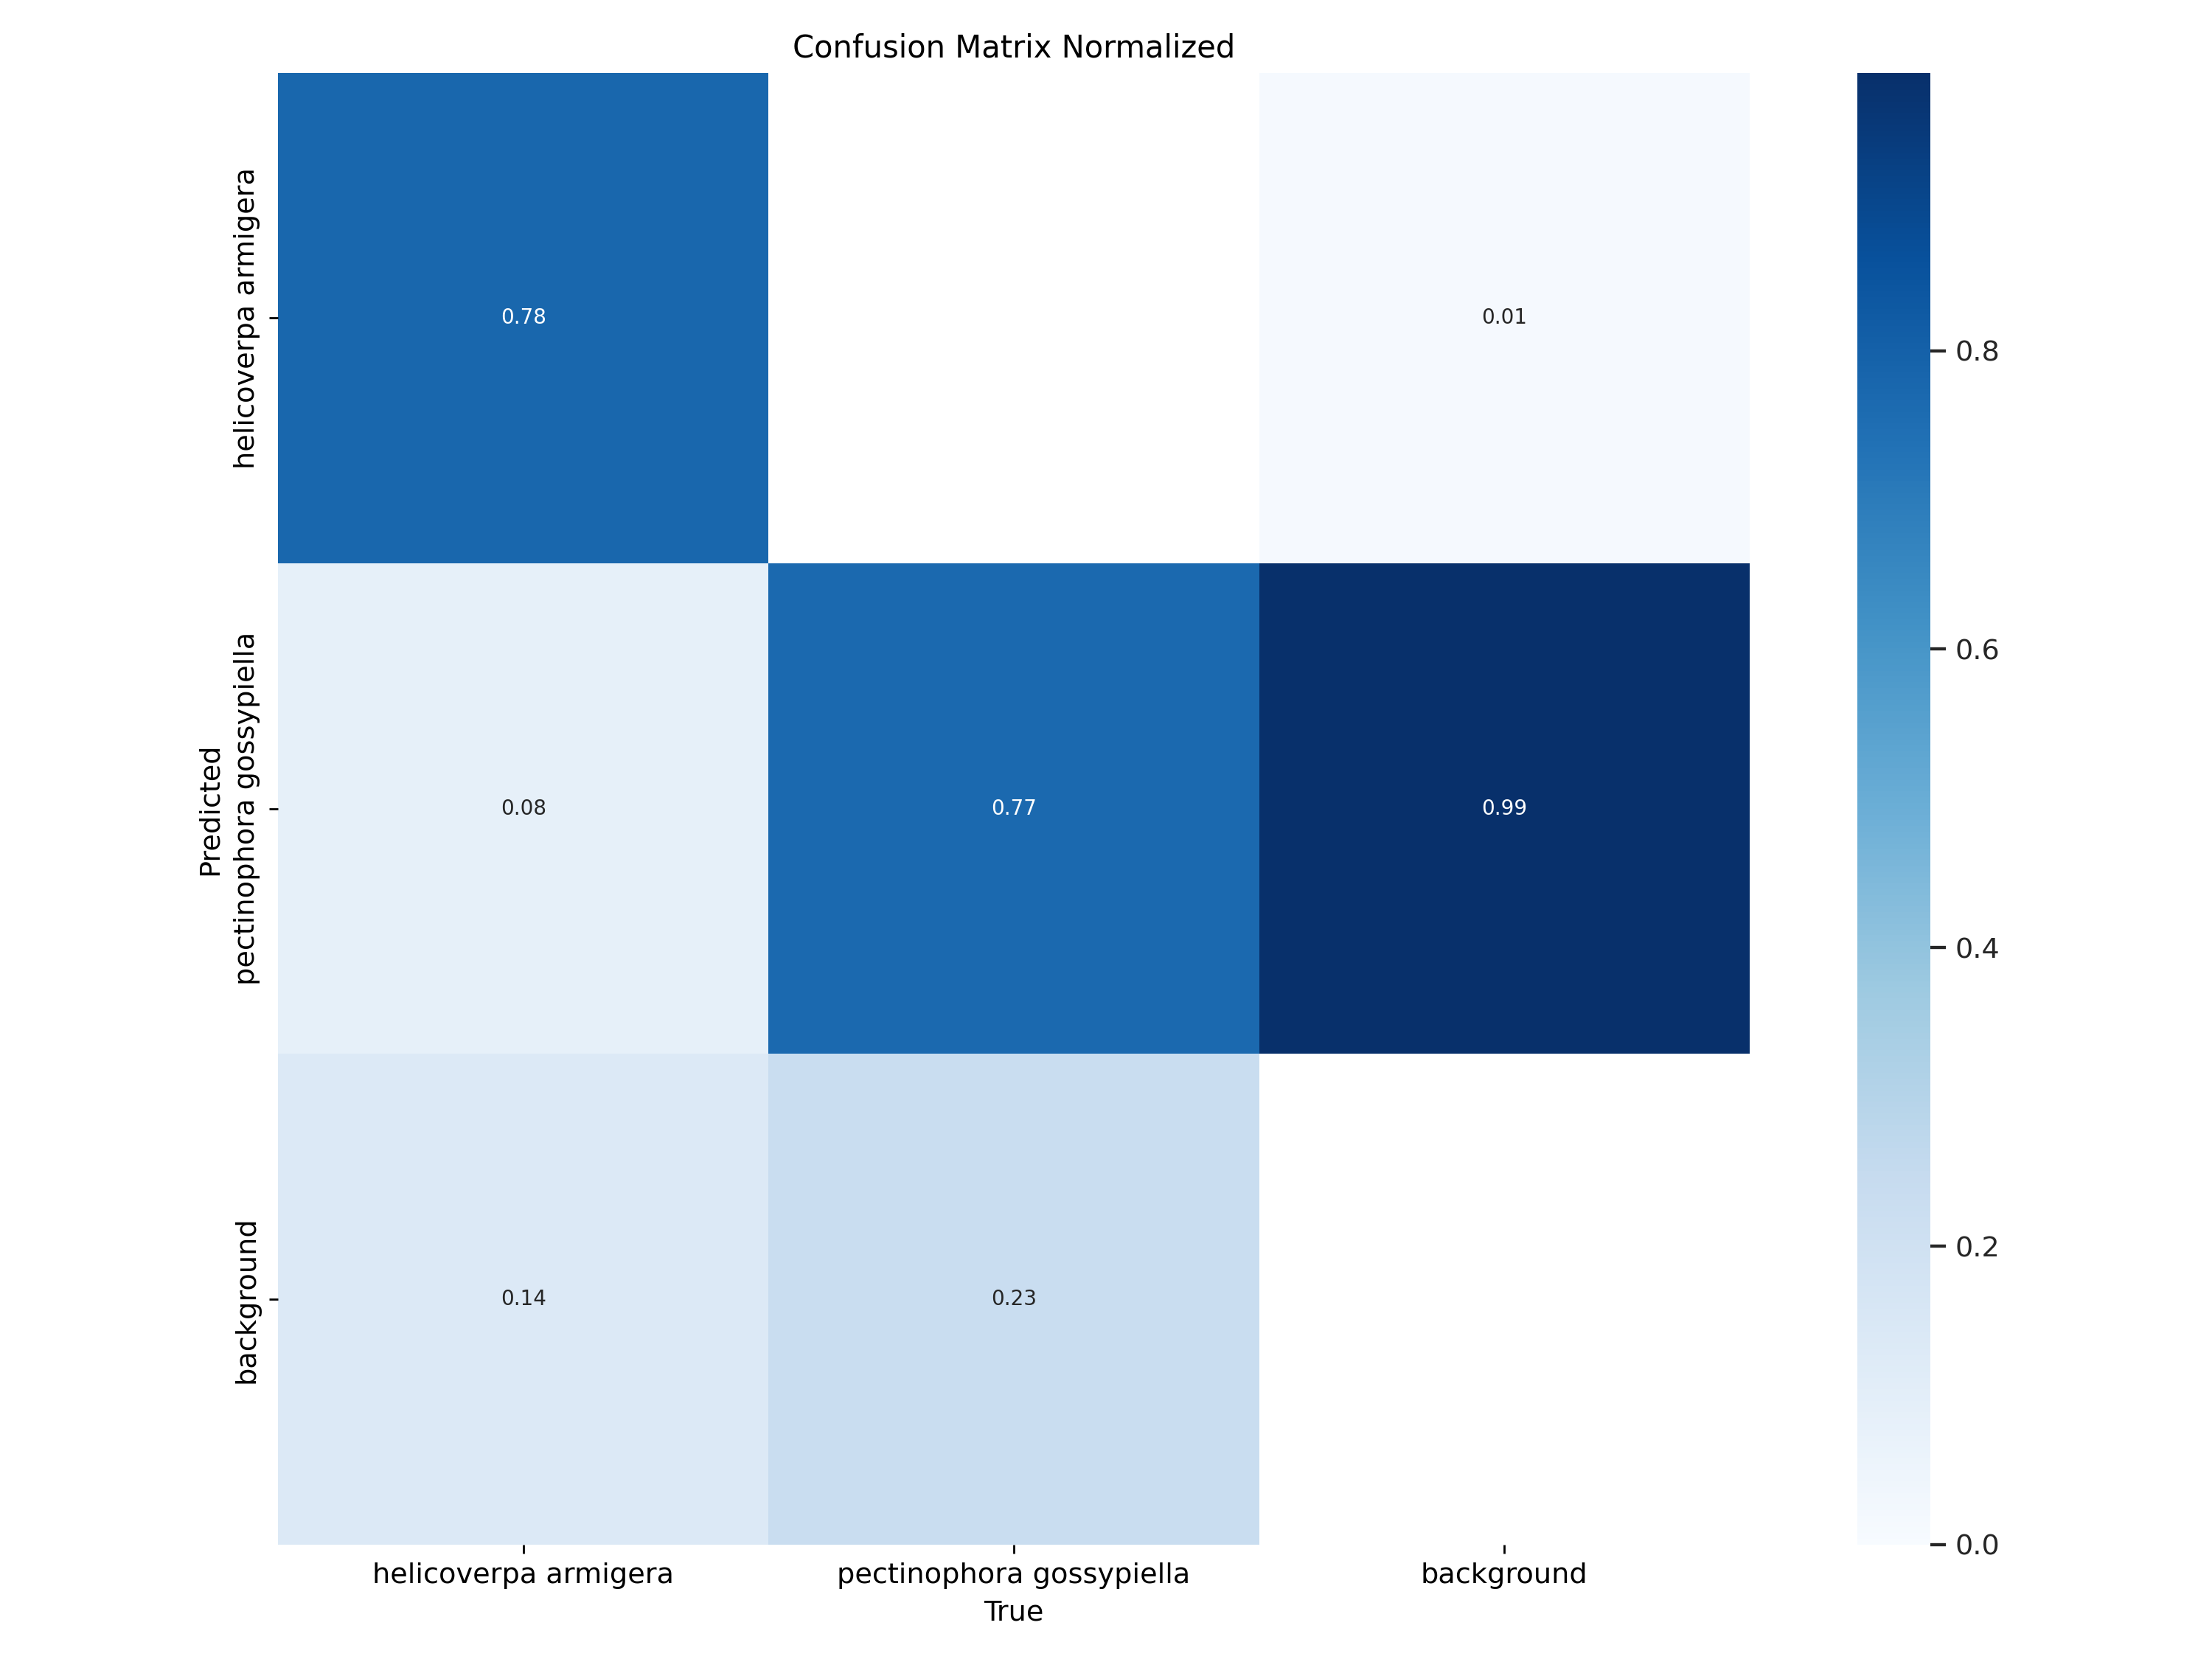

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train3/confusion_matrix_normalized.png")
im.show()

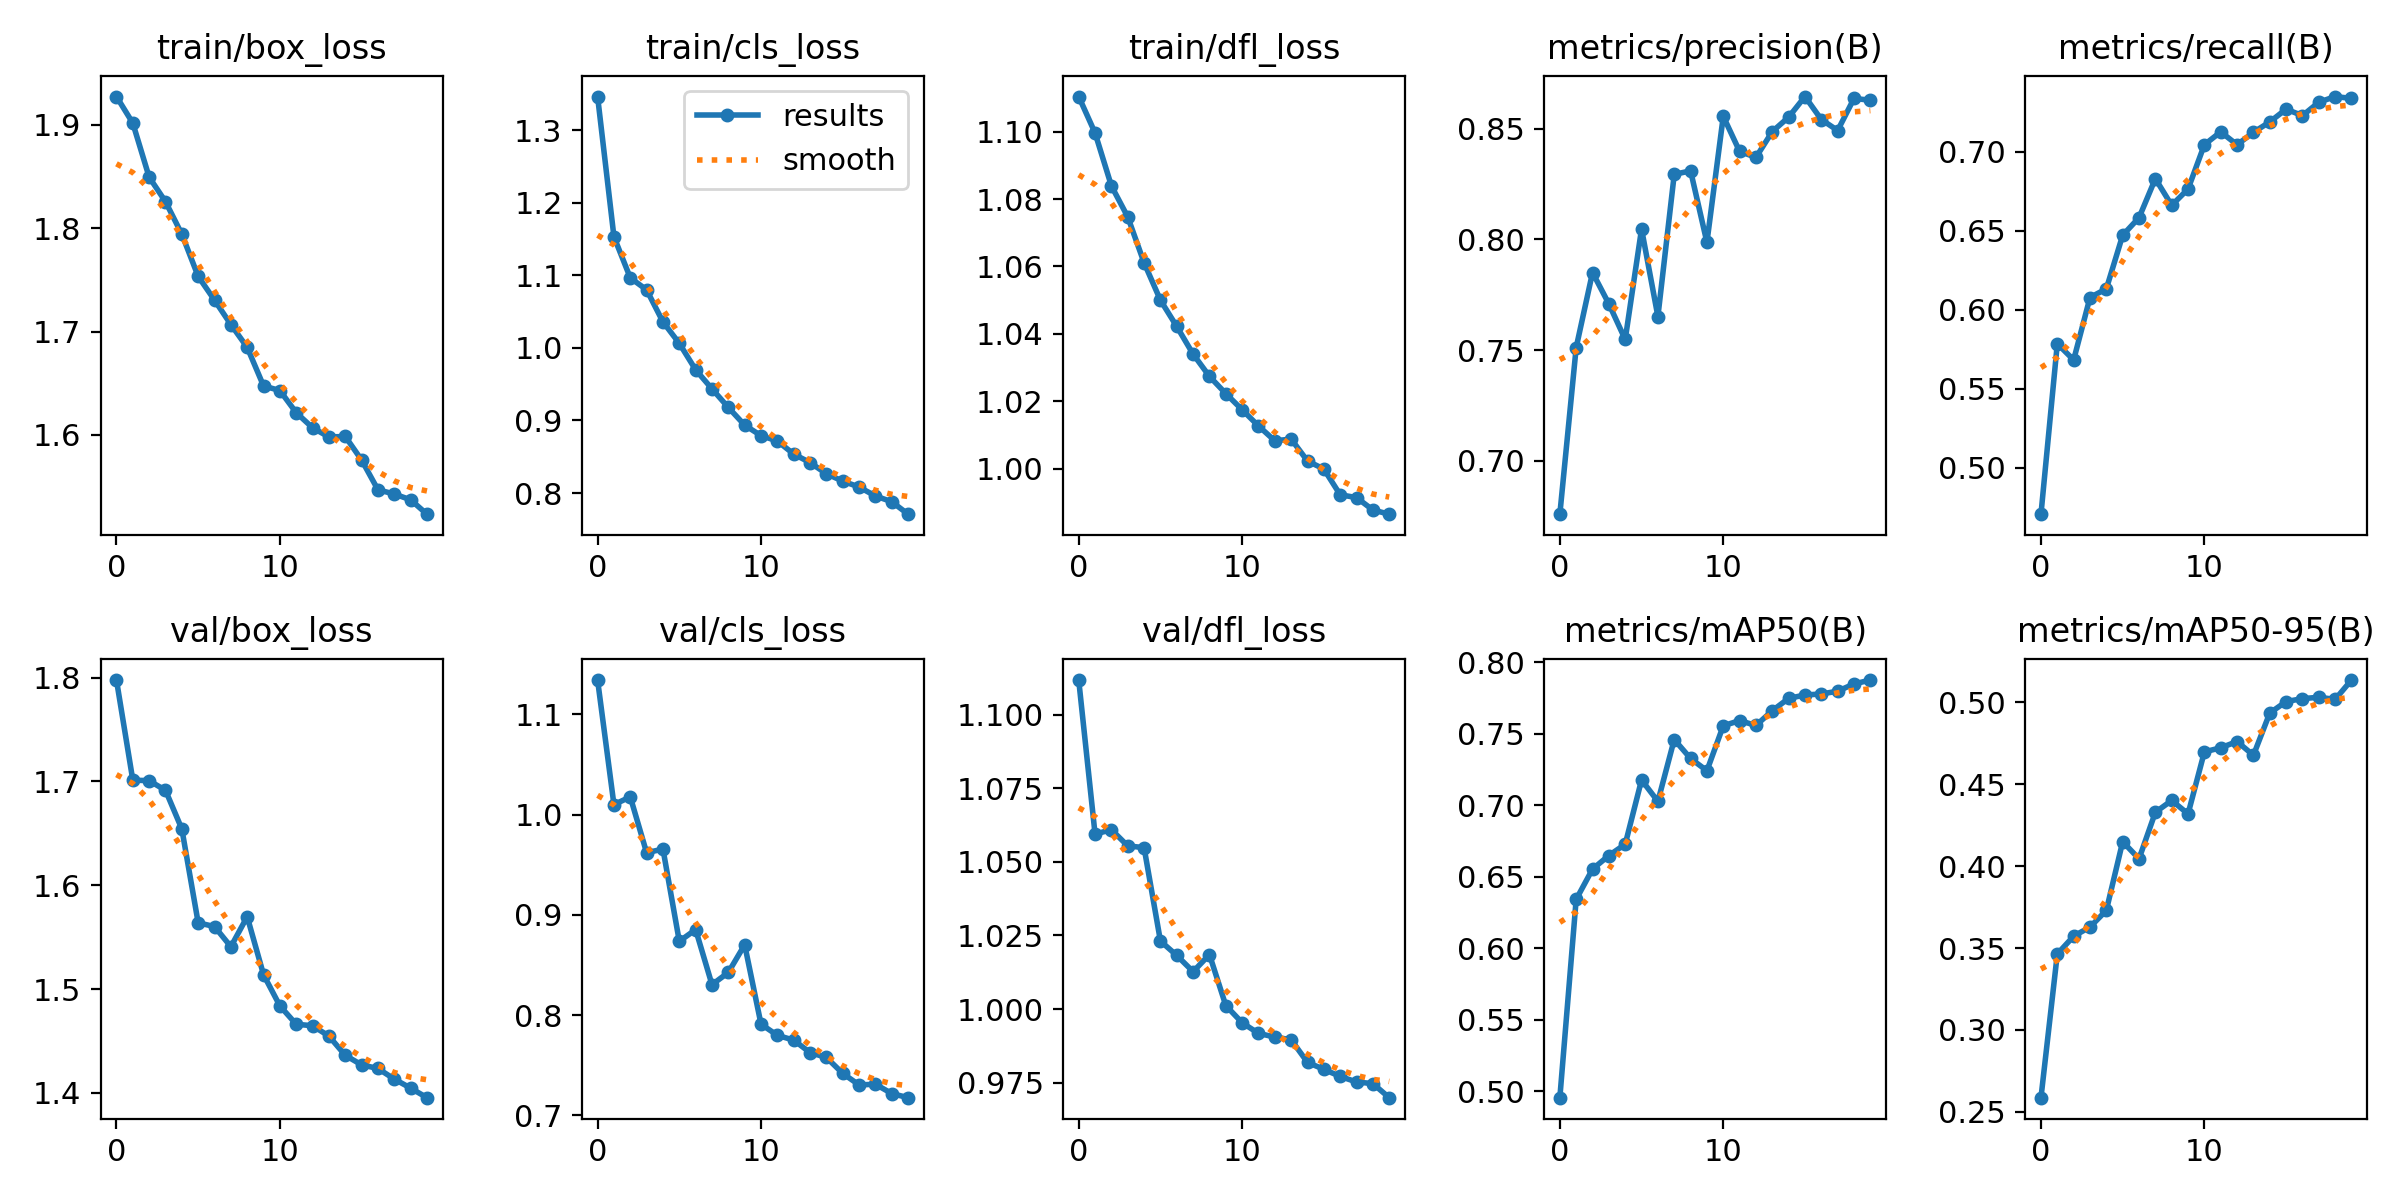

In [ ]:
from PIL import Image
im = Image.open("/content/runs/detect/train3/results.png")
im.show()

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/finetuned_yolov8s.pt')
model.val(split = "test")

Ultralytics YOLOv8.0.125 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11126358 parameters, 0 gradients
val: Scanning /content/data/labels/test.cache... 3086 images, 1480 backgrounds, 0 corrupt: 100%|██████████| 3086/3086 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 193/193 [09:39<00:00,  3.00s/it]
                   all       3086      43190      0.831      0.748      0.794      0.536
  helicoverpa armigera       3086        965      0.845      0.827      0.855      0.678
pectinophora gossypiella       3086      42225      0.817      0.669      0.732      0.395
Speed: 0.3ms preprocess, 9.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val2


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7fe21e9688e0>
fitness: 0.562152057017056
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.67786,       0.395])
names: {0: 'helicoverpa armigera', 1: 'pectinophora gossypiella'}
plot: True
results_dict: {'metrics/precision(B)': 0.831185202457837, 'metrics/recall(B)': 0.7478468726321181, 'metrics/mAP50(B)': 0.7936402242703149, 'metrics/mAP50-95(B)': 0.5364311495444716, 'fitness': 0.562152057017056}
save_dir: PosixPath('runs/detect/val2')
speed: {'preprocess': 0.30216147817734074, 'inference': 8.982851454289177, 'loss': 0.0012426197103919416, 'postprocess': 1.8342768921917008}

## Conteo de plagas

In [ ]:
from ultralytics import YOLO
from datetime import datetime
import pandas as pd

model = YOLO('/content/finetuned_yolov8s.pt')
images_files = ["/content/data/images/test/image_000094.jpg" , "/content/data/images/test/image_000087.jpg"]

results = model(images_files, save = True)
num_class1 = []
num_class2 = []
times = []

#registers = {"Num. helicoverpa armigera": }
for result in results:
   boxes = result.boxes
   names = result.names
   cls = boxes.cls
   labels = [ names[int(c)] for c in cls.tolist()]
   num_classes = [ len([ label for label in labels if label == class_name])  for class_name in names.values()]
   num_class1.append(num_classes[0])
   num_class2.append(num_classes[1])
   times.append(datetime.now())

registers = {"Num. helicoverpa armigera": num_class1, "Num. pectinophora gossypiellas": num_class2, "hora": times, "imagenes":  images_files}
df_registers = pd.DataFrame(registers)
df_registers


0: 640x640 4 helicoverpa armigeras, 1: 640x640 9 pectinophora gossypiellas, 30.8ms
Speed: 5.1ms preprocess, 15.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


Num. helicoverpa armigera  Num. pectinophora gossypiellas  \
0                          4                               0   
1                          0                               9   

                        hora                                    imagenes  
0 2023-07-04 11:38:56.487142  /content/data/images/test/image_000094.jpg  
1 2023-07-04 11:38:56.487335  /content/data/images/test/image_000087.jpg